<a href="https://colab.research.google.com/github/drachmacollector/Stellar-Analytics/blob/main/Stellar_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [ ]:
pp = pprint.PrettyPrinter(indent = 3)

In [ ]:
df = pd.read_csv("supernova_dataset.csv")
print(df.shape)
df.head()

(9564, 26)


,kepid,koi_disposition,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,koi_prad,...,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,10797460,CONFIRMED,9.488036,2.95750,615.8,0.146,35.8,142.0,0.022344,2.26,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,10797460,CONFIRMED,54.418383,4.50700,874.8,0.586,25.8,25.0,0.027954,2.83,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,10811496,CANDIDATE,19.899140,1.78220,10829.0,0.969,76.3,56.0,0.154046,14.60,...,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,10848459,FALSE POSITIVE,1.736952,2.40641,8079.2,1.276,505.6,621.0,0.387394,33.46,...,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,10854555,CONFIRMED,2.525592,1.65450,603.3,0.701,40.9,515.0,0.024064,2.75,...,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


# Counting NaN Values

In [ ]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}

In [ ]:
pp.pprint(nan_columns)

{  'feh_err1': 109,
   'feh_err2': 109,
   'koi_depth': 363,
   'koi_impact': 363,
   'koi_model_snr': 363,
   'koi_num_transits': 1142,
   'koi_prad': 363,
   'koi_ror': 363,
   'logg_err1': 109,
   'logg_err2': 109,
   'mass_err1': 109,
   'mass_err2': 109,
   'radius_err1': 109,
   'radius_err2': 109,
   'st_dens': 109,
   'st_mass': 109,
   'teff_err1': 109,
   'teff_err2': 109}


## Preliminary Cleaning

### Removing Mostly NaN Rows

A threshold is set such that rows in which atleast **20%** of the fields are NaN are dropped.

In [ ]:
df = df[~(df.isnull().sum(axis=1) > int((0.2)*df.shape[1]))]

In [ ]:
print(df.shape)

(9202, 26)


The number of rows has decreased from 9564 to 9202

# Replacing NaN Values

There are two broad types of NaN values present.
* NaN in Error Values - These include the positive and negative error in estimating attributes
* NaN in Measurable Attributes - These include missing values in measuring attributes

## Replacing NaN in Error Values

### Finding Error Attributes with NaN

In [ ]:
missing_error_attribute_names = [attr for attr in df.columns if "err" in attr]
pp.pprint(missing_error_attribute_names)

[  'teff_err1',
   'teff_err2',
   'logg_err1',
   'logg_err2',
   'feh_err1',
   'feh_err2',
   'mass_err1',
   'mass_err2',
   'radius_err1',
   'radius_err2']


the error columns are **effective temperature, surface gravity, metallicity, mass and radius** (of the stars)

Since these are positive and negative error measures for the corresponding attributes, we can do either of the following
* Replace with the mean or median of the attribute errors
* Drop the rows
* Replace with a default value = 0
* Take a look at the percentage error between the column and its associated error

We cannot use regression based techniques to estimate the error since
* A greater set of values does not mean a greater error
* The errors consist of errors while estimating a value and do not depend on any of the attributes

### Finding Distributions of Error Attributes

Let us first extract a slice of the dataset that contains the error attributes

In [ ]:
missing_error_values_df = df[missing_error_attribute_names].copy()
print(missing_error_values_df.shape)
missing_error_values_df.head()

(9202, 10)


,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


We can now find the mean and median of the remaining columns

In [ ]:
error_attribute_means = np.nanmean(missing_error_values_df.values, axis=0)
error_attribute_means

array([ 1.43448000e+02, -1.57469898e+02,  1.12402521e-01, -1.73180178e-01,
        2.16326559e-01, -2.41341230e-01,  1.35677217e-01, -1.38586829e-01,
        4.27612747e-01, -3.54866279e-01])

In [ ]:
error_attribute_medians = np.nanmedian(missing_error_values_df.values, axis=0)
error_attribute_medians

array([ 1.53e+02, -1.49e+02,  7.40e-02, -1.93e-01,  2.20e-01, -2.60e-01,
        1.15e-01, -9.79e-02,  3.56e-01, -1.14e-01])

There seems to be some difference in the median and mean values, suggesting skewed data for attributes.<br>
We might need to plot each and decide when we can take the mean or the median.

## Replacing NaN in Effective Temperature

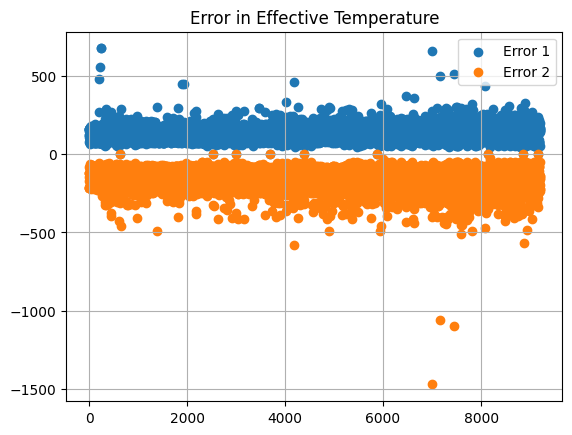

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["teff_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["teff_err2"].values, label = "Error 2")
plt.title("Error in Effective Temperature")
plt.grid()
plt.legend()
plt.show()

### Viewing Frequency Distribution

#### Positive Error

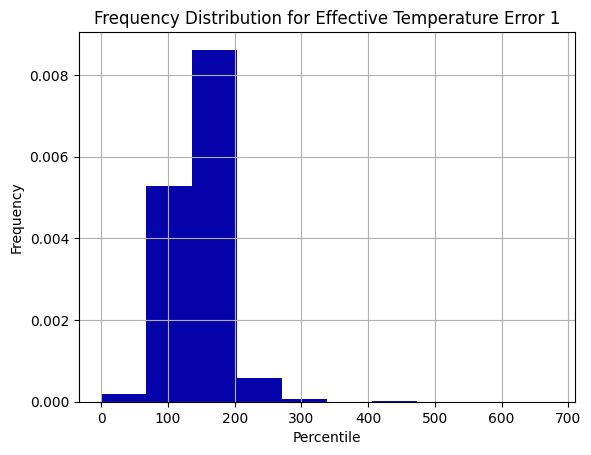

In [ ]:
plt.hist(missing_error_values_df["teff_err1"].values, color = "#0504aa", density=True)
plt.title("Frequency Distribution for Effective Temperature Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

#### Negative Error

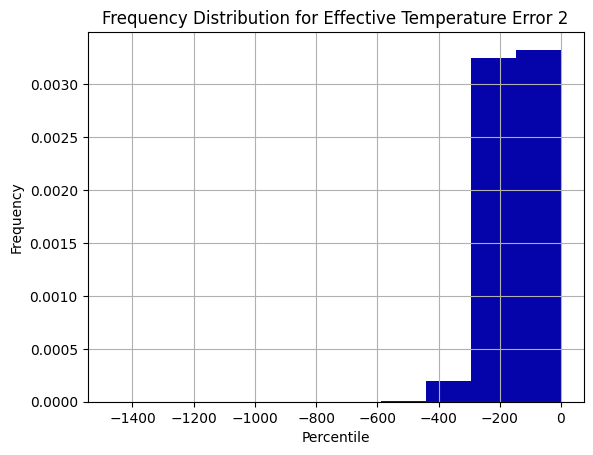

In [ ]:
plt.hist(missing_error_values_df["teff_err2"].values, color="#0504aa", density = True)
plt.title("Frequency Distribution for Effective Temperature Error 2")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

## Replacing NaN in Surface Gravity

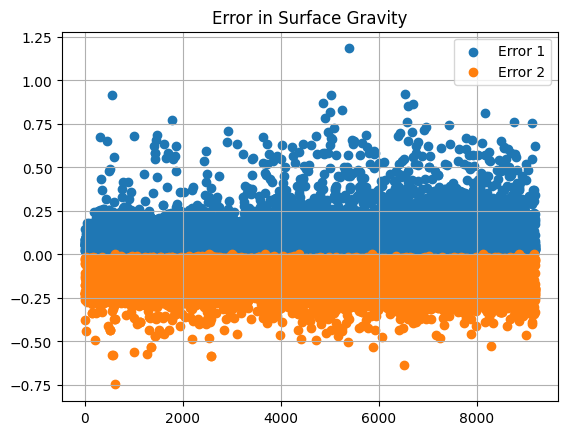

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["logg_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["logg_err2"].values, label = "Error 2")
plt.title("Error in Surface Gravity")
plt.legend()
plt.grid()

### Viewing Frequency Distribution

#### Positive Error

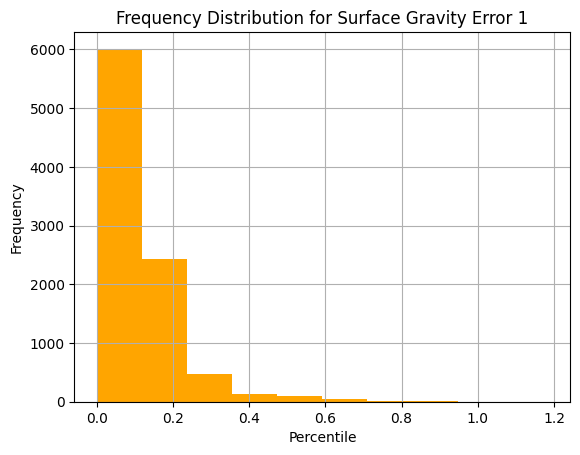

In [ ]:
plt.hist(missing_error_values_df["logg_err1"].values, color="orange")
plt.title("Frequency Distribution for Surface Gravity Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()

#### Negative Error

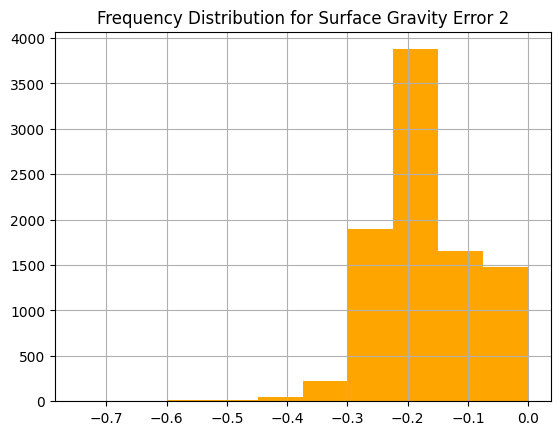

In [ ]:
plt.hist(missing_error_values_df["logg_err2"].values, color="orange")
plt.title("Frequency Distribution for Surface Gravity Error 2")
plt.grid()

## Replacing NaN in Metallicity

### Viewing Frequency Distribution

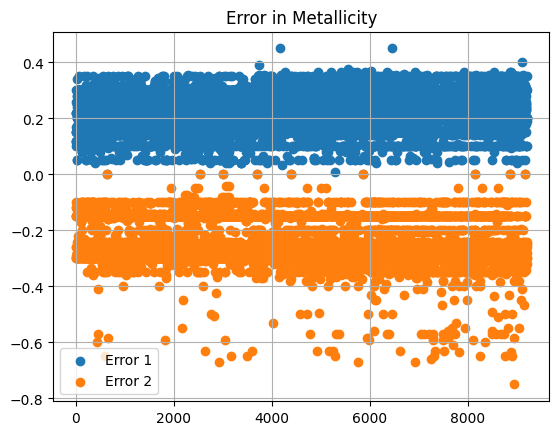

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["feh_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["feh_err2"].values, label = "Error 2")
plt.title("Error in Metallicity")
plt.legend()
plt.grid()

#### Positive Error

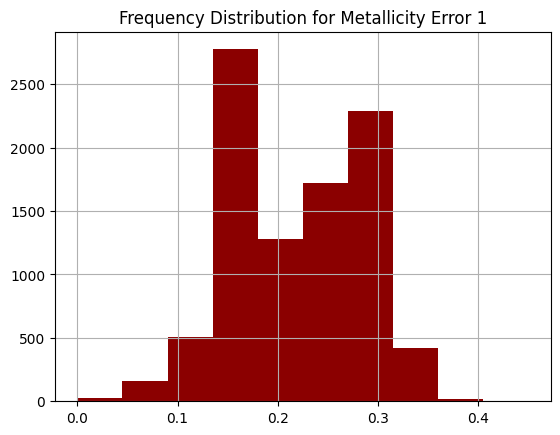

In [ ]:
plt.hist(missing_error_values_df["feh_err1"].values, color="darkred")
plt.title("Frequency Distribution for Metallicity Error 1")
plt.grid()

#### Negative Error

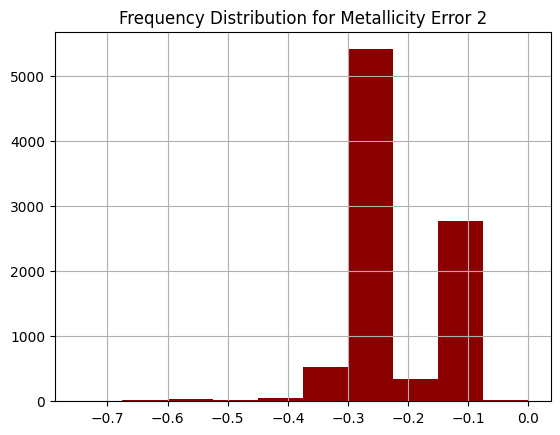

In [ ]:
plt.hist(missing_error_values_df["feh_err2"].values, color="darkred")
plt.title("Frequency Distribution for Metallicity Error 2")
plt.grid()

## Replacing NaN in Star Mass

### Viewing Frequency Distribution

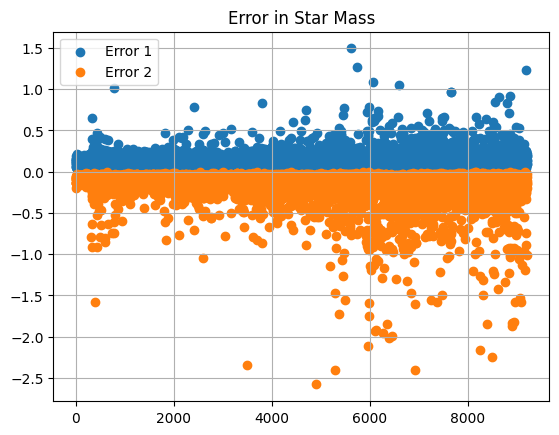

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["mass_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["mass_err2"].values, label = "Error 2")
plt.title("Error in Star Mass")
plt.legend()
plt.grid()

#### Positive Error

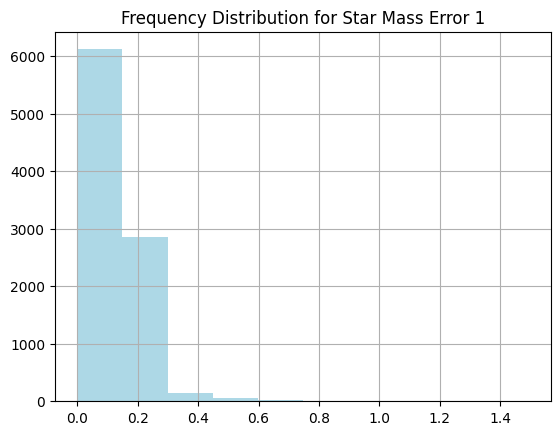

In [ ]:
plt.hist(missing_error_values_df["mass_err1"].values, color="lightblue")
plt.title("Frequency Distribution for Star Mass Error 1")
plt.grid()

#### Negative Error

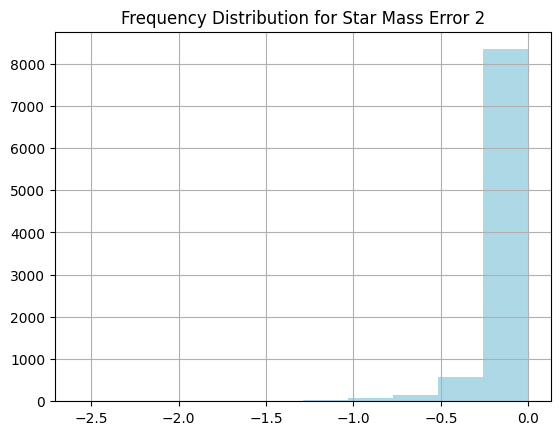

In [ ]:
plt.hist(missing_error_values_df["mass_err2"].values, color="lightblue")
plt.title("Frequency Distribution for Star Mass Error 2")
plt.grid()

## Replacing NaN in Star Radius

### Viewing Frequency Distribution

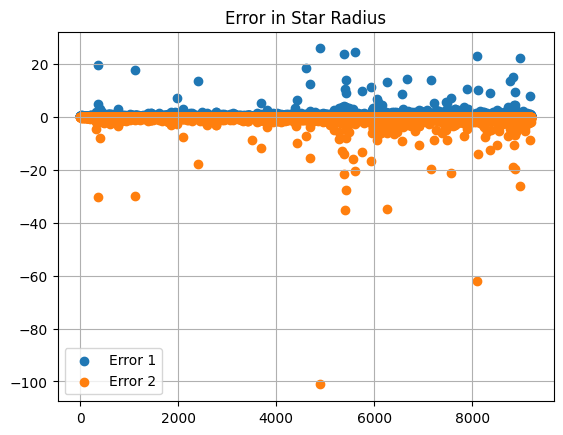

In [ ]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["radius_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["radius_err2"].values, label = "Error 2")
plt.title("Error in Star Radius")
plt.legend()
plt.grid()

#### Positive Error

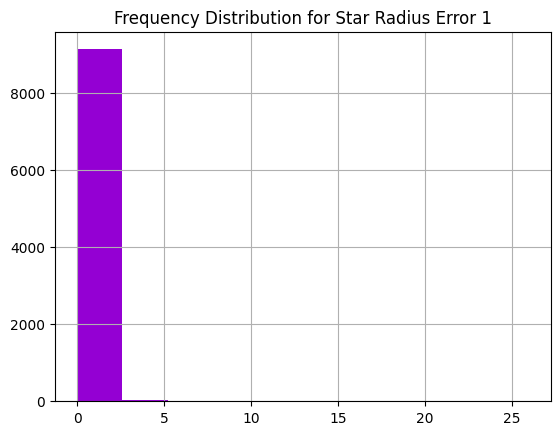

In [ ]:
plt.hist(missing_error_values_df["radius_err1"].values, color="darkviolet")
plt.title("Frequency Distribution for Star Radius Error 1")
plt.grid()

#### Negative Error

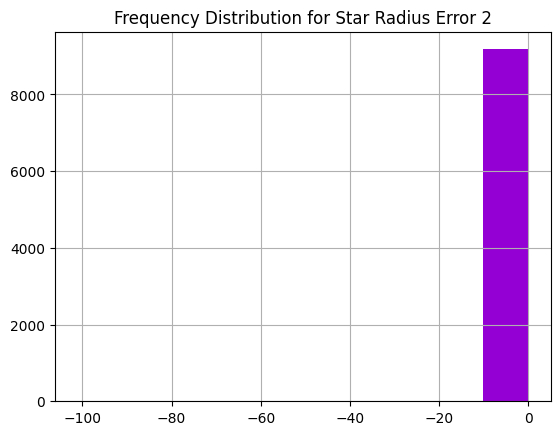

In [ ]:
plt.hist(missing_error_values_df["radius_err2"].values, color="darkviolet")
plt.title("Frequency Distribution for Star Radius Error 2")
plt.grid()

In [ ]:
df[missing_error_attribute_names] = (
    df[missing_error_attribute_names]
    .fillna(df[missing_error_attribute_names].median())
)

## Finding Errors in Non-Error Attributes

In [ ]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{  'koi_depth': 105,
   'koi_impact': 105,
   'koi_model_snr': 105,
   'koi_num_transits': 874,
   'koi_prad': 105,
   'koi_ror': 105}


## Replacing NaN in Transit Depth

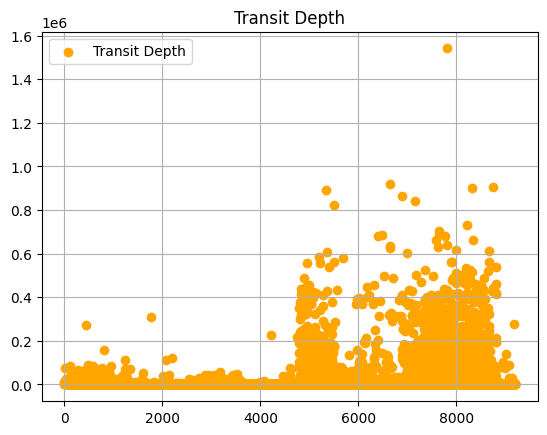

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_depth"].values, label = "Transit Depth", color ="orange")
plt.title("Transit Depth")
plt.legend()
plt.grid()

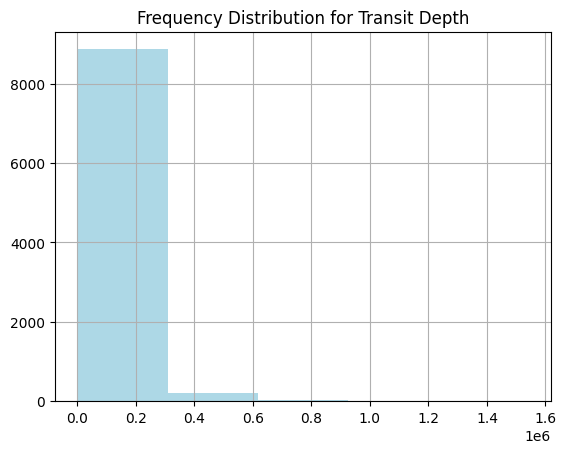

In [ ]:
plt.hist(df["koi_depth"].values, bins=5, color="lightblue")
plt.title("Frequency Distribution for Transit Depth")
plt.grid()

## Replacing NaN in Impact Parameter

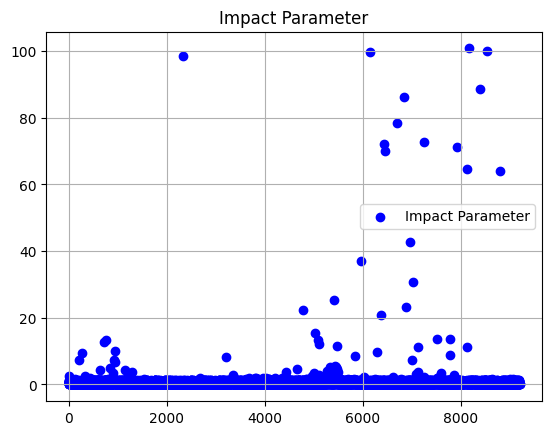

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_impact"].values, label = "Impact Parameter", color="blue")
plt.title("Impact Parameter")
plt.legend()
plt.grid()

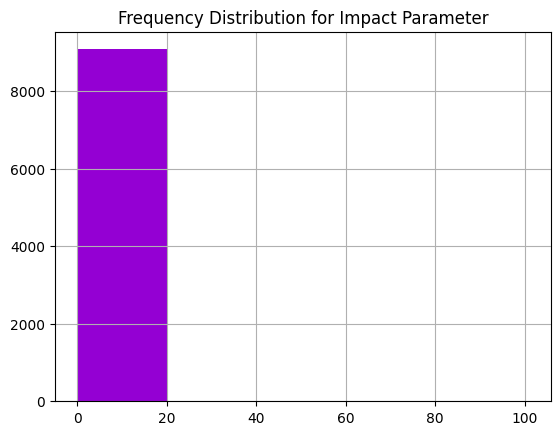

In [ ]:
plt.hist(df["koi_impact"].values, bins=5, color="darkviolet")
plt.title("Frequency Distribution for Impact Parameter")
plt.grid()

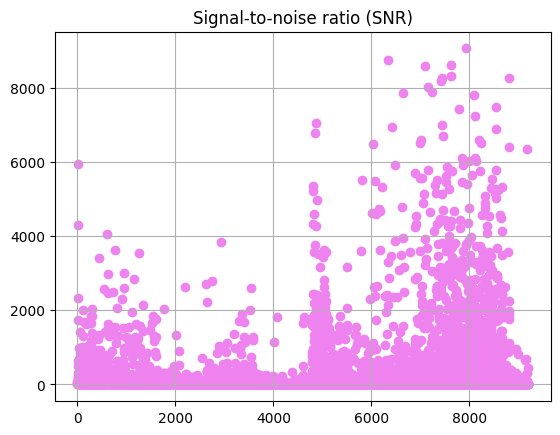

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_model_snr"].values, label = "SNR", color="violet")
plt.title("Signal-to-noise ratio (SNR)")
plt.grid()

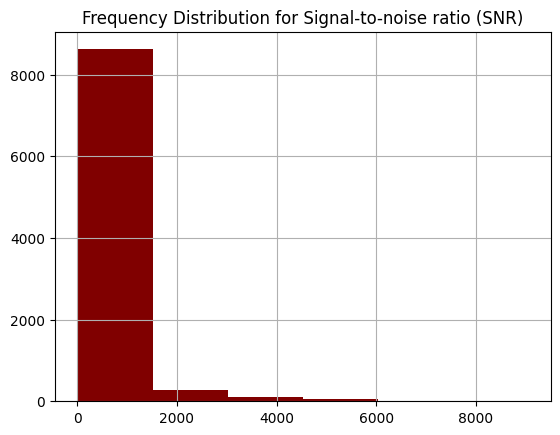

In [ ]:
plt.hist(df["koi_model_snr"].values, color="maroon", bins=6)
plt.title("Frequency Distribution for Signal-to-noise ratio (SNR)")
plt.grid()

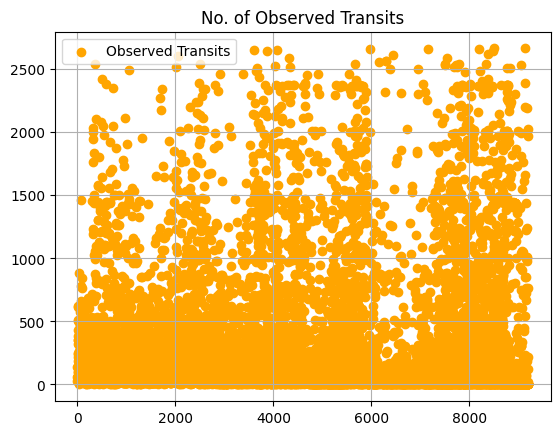

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_num_transits"].values, label = "Observed Transits", color="orange")
plt.title("No. of Observed Transits")
plt.legend()
plt.grid()

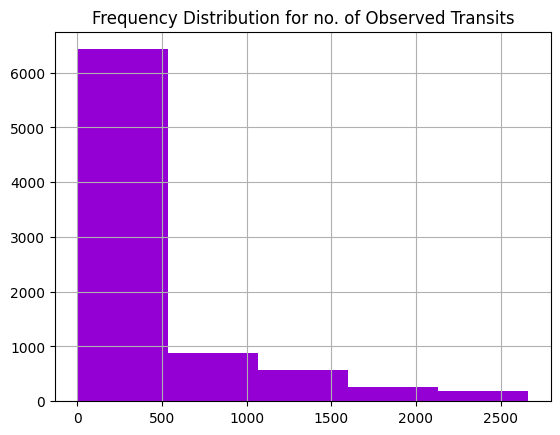

In [ ]:
plt.hist(df["koi_num_transits"].values, bins=5, color="darkviolet")
plt.title("Frequency Distribution for no. of Observed Transits")
plt.grid()

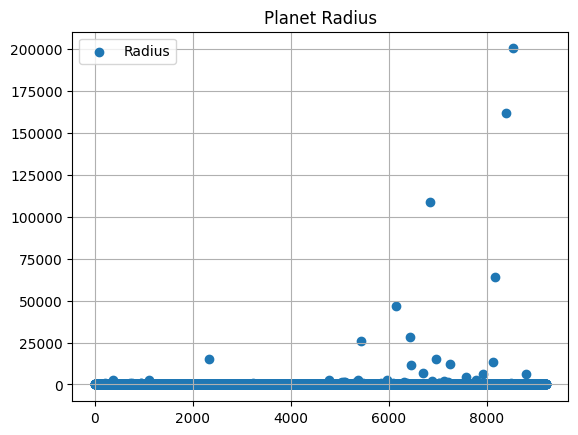

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_prad"].values, label = "Radius")
plt.title("Planet Radius")
plt.legend()
plt.grid()

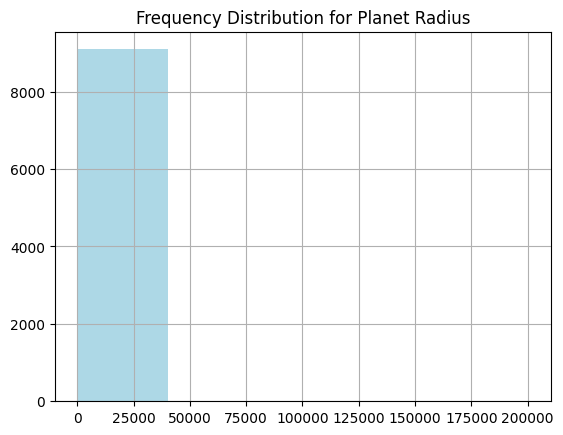

In [ ]:
plt.hist(df["koi_prad"].values, color="lightblue", bins = 5)
plt.title("Frequency Distribution for Planet Radius")
plt.grid()

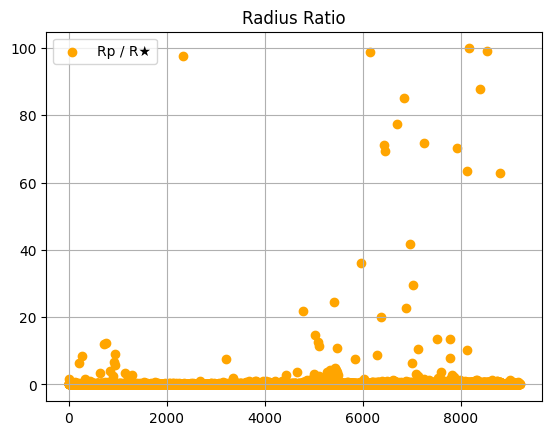

In [ ]:
plt.scatter(range(df.shape[0]), df["koi_ror"].values, label = "Rp / R★", color="orange")
plt.title("Radius Ratio")
plt.legend()
plt.grid()

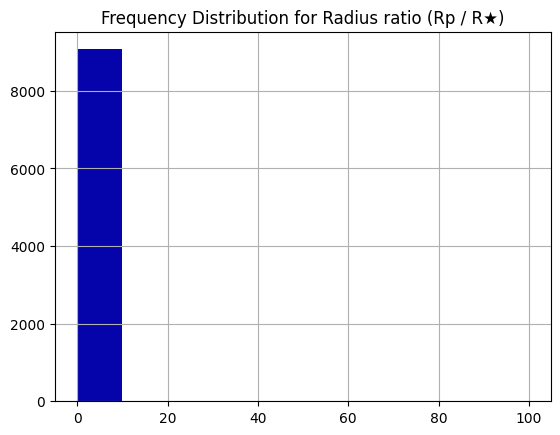

In [ ]:
plt.hist(df["koi_ror"].values, color="#0504aa")
plt.title("Frequency Distribution for Radius ratio (Rp / R★)")
plt.grid()

In [ ]:
cols = [
    "koi_depth",
    "koi_impact",
    "koi_model_snr",
    "koi_num_transits",
    "koi_prad",
    "koi_ror",
]

df[cols] = df[cols].fillna(df[cols].median())

In [ ]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{}


In [ ]:
df.to_csv("[CLEANED]supernova-dataset.csv")

# Visualization

In [ ]:
import plotly.express as px
import pandas as pd
df = pd.read_csv("[CLEANED]supernova-dataset.csv")
print(df.shape)
df.head()

(9202, 27)


,Unnamed: 0,kepid,koi_disposition,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,...,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,0,10797460,CONFIRMED,9.488036,2.95750,615.8,0.146,35.8,142.0,0.022344,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,1,10797460,CONFIRMED,54.418383,4.50700,874.8,0.586,25.8,25.0,0.027954,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,2,10811496,CANDIDATE,19.899140,1.78220,10829.0,0.969,76.3,56.0,0.154046,...,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,3,10848459,FALSE POSITIVE,1.736952,2.40641,8079.2,1.276,505.6,621.0,0.387394,...,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,4,10854555,CONFIRMED,2.525592,1.65450,603.3,0.701,40.9,515.0,0.024064,...,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


### disposition

In [ ]:
px.histogram(df, x="koi_disposition")

### planet properties

In [ ]:
(df["koi_prad"] <= 0).sum()

np.int64(0)

In [ ]:
px.histogram(df, x="koi_prad", color="koi_disposition")

In [ ]:
px.histogram(df, x="koi_period", color="koi_disposition", log_x=True)

In [ ]:
px.scatter(df, x="koi_period", y="koi_prad", color="koi_disposition")

In [ ]:
px.scatter(df, x="koi_depth", y="koi_prad", color="koi_disposition")

In [ ]:
px.scatter(df, x="koi_model_snr", y="koi_num_transits", color="koi_disposition")

### star properties

In [ ]:
px.histogram(df, x="st_teff", color="koi_disposition")

In [ ]:
px.histogram(df, x="st_radius", color="koi_disposition")

In [ ]:
px.scatter(df, x="st_teff", y="koi_prad", color="koi_disposition")

In [ ]:
px.scatter(df, x="st_radius", y="koi_period", color="koi_disposition")

# Cluster Analysis

In [336]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, DBSCAN, SpectralClustering
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer

In [337]:
df = pd.read_csv("[CLEANED]supernova-dataset.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9202, 26)


,kepid,koi_disposition,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,koi_prad,...,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,10797460,CONFIRMED,9.488036,2.95750,615.8,0.146,35.8,142.0,0.022344,2.26,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
1,10797460,CONFIRMED,54.418383,4.50700,874.8,0.586,25.8,25.0,0.027954,2.83,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.13150,-0.08685,0.465,-0.114
2,10811496,CANDIDATE,19.899140,1.78220,10829.0,0.969,76.3,56.0,0.154046,14.60,...,158.0,-171.0,0.044,-0.176,0.26,-0.26,0.10375,-0.11465,0.237,-0.078
3,10848459,FALSE POSITIVE,1.736952,2.40641,8079.2,1.276,505.6,621.0,0.387394,33.46,...,157.0,-144.0,0.053,-0.223,0.30,-0.26,0.09995,-0.07165,0.364,-0.068
4,10854555,CONFIRMED,2.525592,1.65450,603.3,0.701,40.9,515.0,0.024064,2.75,...,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.19050,-0.13700,0.442,-0.133


## selecting columns

We eliminate all the columns that are either of the following
*   Assigned after other values are measured from readings
*   Are error attributes
* Contain ID or name attributes

In [338]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = [c for c in ALL_COLUMNS if c not in EXCLUDE]

In [339]:
print(len(TO_USE))
df[TO_USE].head()

14


,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,koi_prad,st_teff,st_logg,st_met,st_mass,st_radius,st_dens
0,9.488036,2.95750,615.8,0.146,35.8,142.0,0.022344,2.26,5762.0,4.426,0.14,0.9850,0.989,1.4690
1,54.418383,4.50700,874.8,0.586,25.8,25.0,0.027954,2.83,5762.0,4.426,0.14,0.9850,0.989,1.4690
2,19.899140,1.78220,10829.0,0.969,76.3,56.0,0.154046,14.60,5853.0,4.544,-0.18,0.9610,0.868,2.0685
3,1.736952,2.40641,8079.2,1.276,505.6,621.0,0.387394,33.46,5805.0,4.546,-0.52,0.8315,0.803,2.3120
4,2.525592,1.65450,603.3,0.701,40.9,515.0,0.024064,2.75,6031.0,4.438,0.07,1.0950,1.046,1.3470


## Extracting Dataframe Subset
We extract only those rows which are **CONFIRMED** examples i.e. the disposition value is **CONFIRMED**.

In [340]:
new_df = df[df["koi_disposition"] == "CONFIRMED"]
print(new_df.shape)
new_df.head()

(2745, 26)


,kepid,koi_disposition,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,koi_prad,...,teff_err1,teff_err2,logg_err1,logg_err2,feh_err1,feh_err2,mass_err1,mass_err2,radius_err1,radius_err2
0,10797460,CONFIRMED,9.488036,2.9575,615.8,0.146,35.8,142.0,0.022344,2.26,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.1315,-0.08685,0.465,-0.114
1,10797460,CONFIRMED,54.418383,4.5070,874.8,0.586,25.8,25.0,0.027954,2.83,...,123.0,-123.0,0.068,-0.243,0.15,-0.15,0.1315,-0.08685,0.465,-0.114
4,10854555,CONFIRMED,2.525592,1.6545,603.3,0.701,40.9,515.0,0.024064,2.75,...,151.0,-207.0,0.070,-0.222,0.17,-0.29,0.1905,-0.13700,0.442,-0.133
5,10872983,CONFIRMED,11.094321,4.5945,1517.5,0.538,66.5,95.0,0.036779,3.90,...,163.0,-217.0,0.054,-0.229,0.22,-0.30,0.1593,-0.14265,0.414,-0.105
6,10872983,CONFIRMED,4.134435,3.1402,686.0,0.762,40.2,240.0,0.026133,2.77,...,163.0,-217.0,0.054,-0.229,0.22,-0.30,0.1593,-0.14265,0.414,-0.105


### extracting values

In [341]:
X = new_df[TO_USE].values
y = new_df["koi_disposition"].values

In [342]:
X_scaler = StandardScaler()
X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_2d = pca.transform(X_scaled)

In [343]:
X_2d.shape

(2745, 2)

## visualization

In [344]:
def elbowVisualiser(model_instance, X_data, metric=None):
    if metric is None:
        visualizer = KElbowVisualizer(model_instance, k=(4,12))
    else:
        visualizer = KElbowVisualizer(model_instance, k=(4,12), metric=metric)
    visualizer.fit(X_data)
    visualizer.show(f"{model_instance}_elbow.png", dpi=600)


def interclusterDistanceVisualisation(model_instance, X_data):
    visualizer = InterclusterDistance(model_instance)
    visualizer.fit(X_data)
    visualizer.show(f"{model_instance}_inter_cluster_dist.png", dpi=600)


def silhouetteVisualisation(model_instance, X_data):
    visualizer = SilhouetteVisualizer(model_instance, colors='yellowbrick')
    visualizer.fit(X_data)
    visualizer.show(f"{model_instance}_ss.png", dpi=600)


def viewKMeansScatter(model_instance):
    clust_labels = model_instance.predict(X_scaled)
    temp_df = new_df[TO_USE].copy()
    temp_df["Class"] = clust_labels
    unique_classes = list(range(model_instance.n_clusters))
    print(temp_df.groupby("Class").median())
    plt.grid()
    for cls in unique_classes:
        sub_df = temp_df[temp_df["Class"] == cls]
        if not sub_df.empty: # Add this check for empty sub_df
            temp_X = sub_df[[col for col in temp_df.columns if col != "Class"]].values
            temp_X_2d = pca.transform(X_scaler.transform(temp_X))
            plt.grid()
            #print(X_2d.shape)
            plt.scatter(temp_X_2d[:, 0], temp_X_2d[:, 1], label=cls)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.savefig(f"{model_instance}_scatter.png", dpi=600)
    return temp_df.groupby("Class").median()

def viewAggScatter(model_instance):
    clust_labels = model_instance.fit_predict(X_scaled)
    temp_df = new_df[TO_USE].copy()
    temp_df["Class"] = clust_labels
    unique_classes = list(range(model_instance.n_clusters))
    print(temp_df.groupby("Class").median())
    plt.grid()
    for cls in unique_classes:
        sub_df = temp_df[temp_df["Class"] == cls]
        if not sub_df.empty: # Add this check for empty sub_df
            temp_X = sub_df[[col for col in temp_df.columns if col != "Class"]].values
            temp_X_2d = pca.transform(X_scaler.transform(temp_X))
            #print(X_2d.shape)
            plt.grid()
            plt.scatter(temp_X_2d[:, 0], temp_X_2d[:, 1], label=cls)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.savefig(f"agg_scatter_{model_instance}.png", dpi=600)
    plt.show()

def getVisualisationPCA(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)

    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )

    pca_df["TARGET"] = y
    labels = np.unique(y)

    colors = cm.plasma(np.linspace(0, 1, len(labels)))
    plt.grid()
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )

    plt.legend()
    plt.grid()

/tmp/ipython-input-707043443.py:81: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



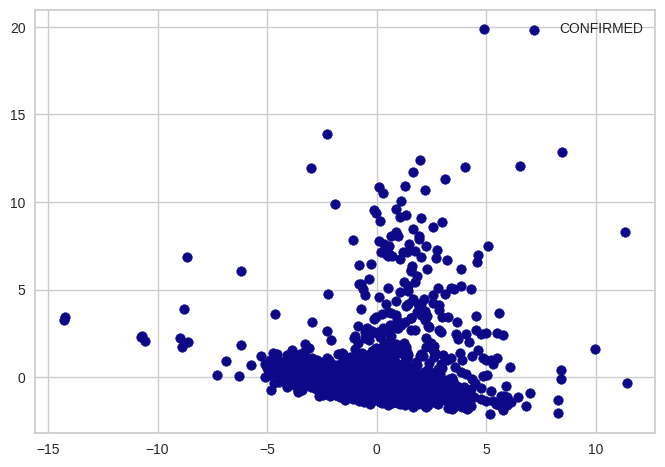

In [345]:
getVisualisationPCA(X, y)

## KMeans Clustering

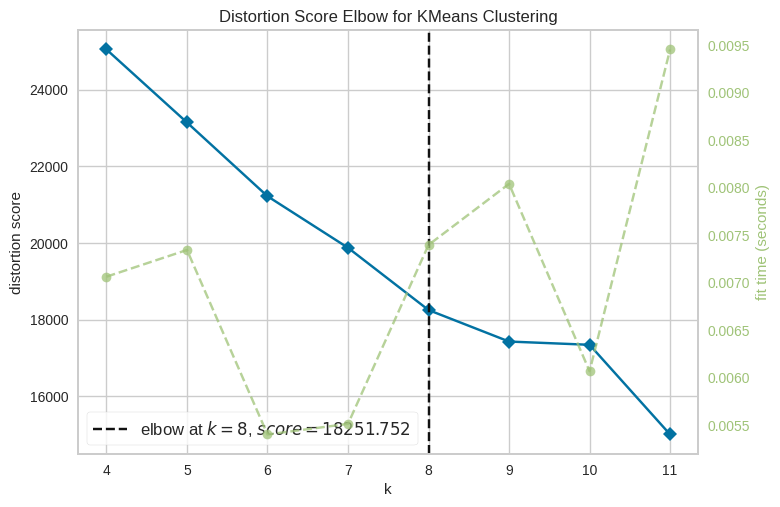

In [346]:
kmeans_model_for_elbow = KMeans(random_state=0)
elbowVisualiser(kmeans_model_for_elbow, X_scaled)

In [347]:
K=7
kmeans_final_model = KMeans(K, max_iter=500, random_state=0)
kmeans_final_model.fit(X_scaled)

KMeans(max_iter=500, n_clusters=7, random_state=0)

       koi_period  koi_duration  koi_depth  koi_impact  koi_model_snr  \
Class                                                                   
0       19.593964      4.629000     507.45      0.6610          27.40   
1        4.446079      3.224025   10564.40      0.3010        1015.75   
2        5.091928      2.513150     330.45      0.2260          25.60   
3      182.592235     10.821950    1050.95      0.2580          47.15   
4       16.486867      4.382300     758.90      1.2280          22.60   
5        9.427614      2.357050     815.25      0.3885          30.30   
6       12.651506      4.895700     210.05      0.4685          29.95   

       koi_num_transits   koi_ror  koi_prad  st_teff  st_logg  st_met  \
Class                                                                   
0                  64.0  0.022650      2.50   5839.0   4.4615 -0.1355   
1                 281.0  0.098905     11.67   5771.0   4.4425  0.0200   
2                 244.5  0.017133      1.68   5440

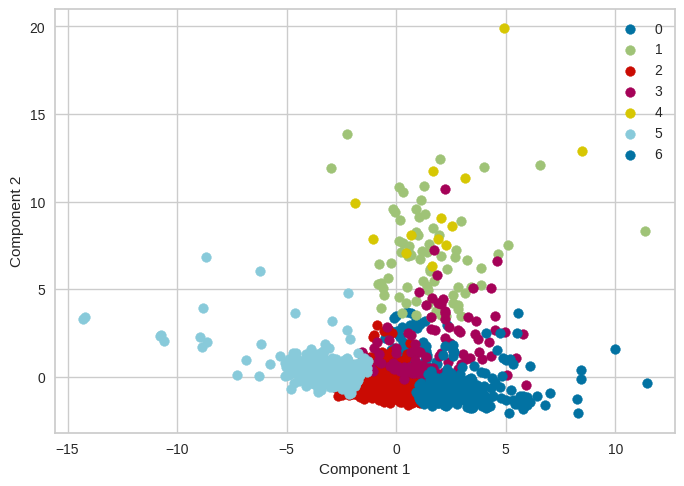

In [348]:
t=viewKMeansScatter(kmeans_final_model)

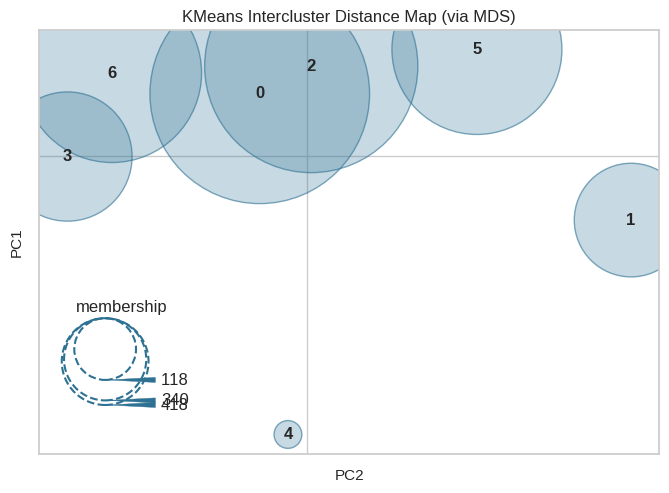

In [349]:
interclusterDistanceVisualisation(kmeans_final_model, X_scaled)

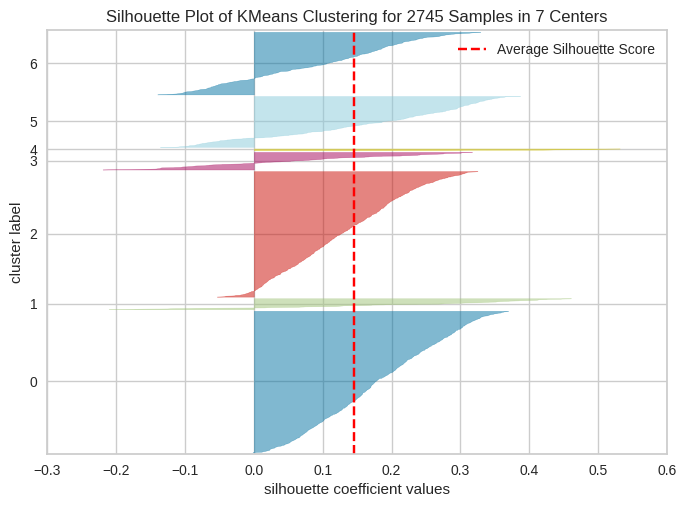

In [350]:
silhouetteVisualisation(kmeans_final_model, X_scaled)

## Agglomerative Clustering

In [351]:
def plot_dendrogram(X):
    de = dendrogram(linkage(X, method='ward'))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.grid()
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.savefig("dendogram.png", dpi=600)

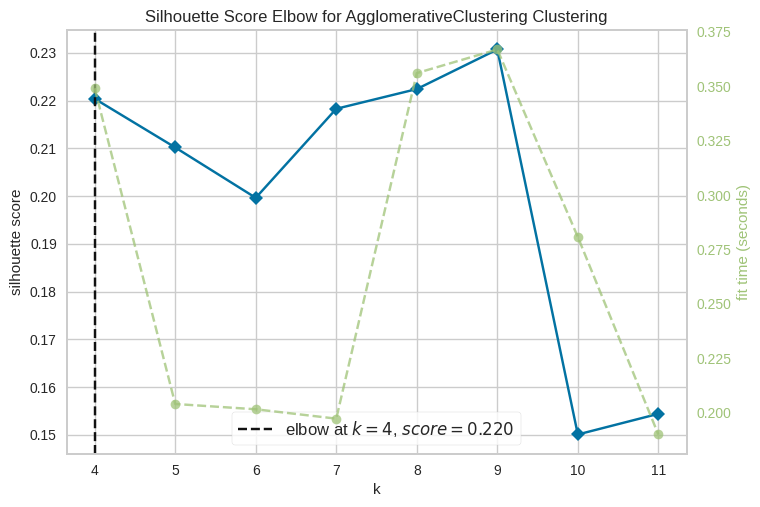

In [352]:
agg_model_for_elbow = AgglomerativeClustering()
elbowVisualiser(agg_model_for_elbow, X_scaled, metric='silhouette')

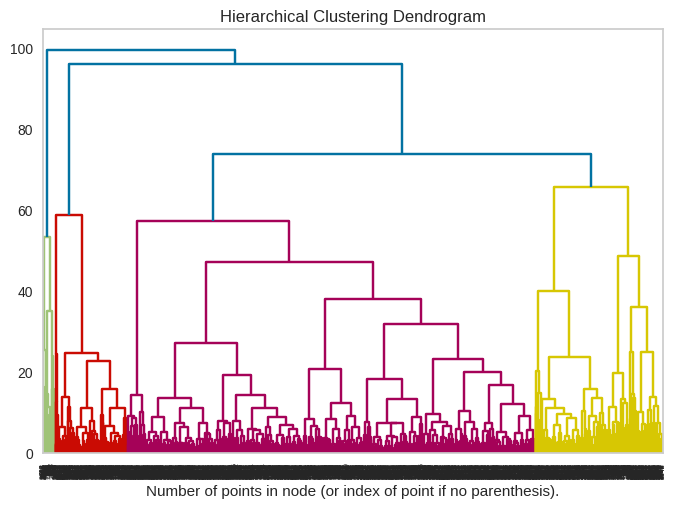

In [353]:
plot_dendrogram(X_scaled)

       koi_period  koi_duration  koi_depth  koi_impact  koi_model_snr  \
Class                                                                   
0        3.880343      3.208165   14255.75      0.3690        1150.05   
1       11.388402      3.466000     426.70      0.3920          26.20   
2       92.101934      8.518500    2100.25      0.2670          84.45   
3        8.799970      2.339500     764.25      0.3305          30.35   
4       11.650588      4.806950     184.85      0.6490          28.50   
5        4.485592      1.096000    1821.00      0.4610          24.30   
6        0.916142      1.339400     215.10      0.3180          25.30   

       koi_num_transits   koi_ror  koi_prad  st_teff  st_logg  st_met  \
Class                                                                   
0                 338.0  0.120103    13.185   5699.5   4.4585   -0.02   
1                 109.0  0.019868     2.140   5727.0   4.4870   -0.08   
2                  12.0  0.042489     4.885   5756

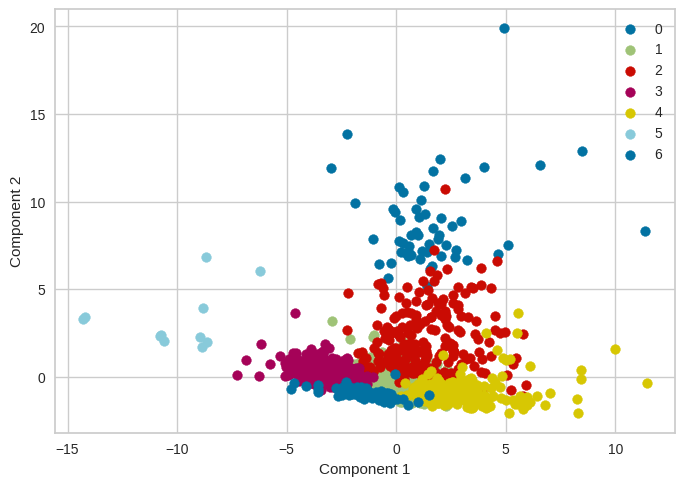

In [354]:
K=7
agg_final_model = AgglomerativeClustering(n_clusters=K)
viewAggScatter(agg_final_model)

## Obtaining Trends

In [355]:
t.head()

,koi_period,koi_duration,koi_depth,koi_impact,koi_model_snr,koi_num_transits,koi_ror,koi_prad,st_teff,st_logg,st_met,st_mass,st_radius,st_dens
Class,,,,,,,,,,,,,,
0,19.593964,4.629000,507.45,0.661,27.40,64.0,0.022650,2.50,5839.0,4.4615,-0.1355,0.964250,0.972,1.43525
1,4.446079,3.224025,10564.40,0.301,1015.75,281.0,0.098905,11.67,5771.0,4.4425,0.0200,0.997700,0.995,1.40975
2,5.091928,2.513150,330.45,0.226,25.60,244.5,0.017133,1.68,5440.0,4.5280,-0.0200,0.885950,0.853,1.93550
3,182.592235,10.821950,1050.95,0.258,47.15,7.0,0.031909,3.43,5756.0,4.4310,-0.0500,0.970975,1.012,1.18500
4,16.486867,4.382300,758.90,1.228,22.60,74.0,0.274887,28.47,5896.0,4.4580,-0.1400,1.020000,0.972,1.56600


In [356]:
t.std()

,0
koi_period,64.988446
koi_duration,2.888827
koi_depth,3772.810051
koi_impact,0.351765
koi_model_snr,372.473091
koi_num_transits,99.622801
koi_ror,0.095139
koi_prad,9.945019
st_teff,653.441585
st_logg,0.156243
